In [1]:
!pip install tensorflow-ranking==0.5.0
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.7 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 376.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.1 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 73.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuf

**Importing  libraries**

In [2]:
import tensorflow_ranking as tfr
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten
print("TensorFlow version:", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly

TensorFlow version: 2.9.1


### Custom Hamming Loss Metric

In this code  a custom Hamming Loss metric is defined using TensorFlow and Keras. The Hamming Loss is a metric used to evaluate the accuracy of multi-label classification models. Here's an explanation of the code:

#### Custom Metric Class

- A custom metric class named `HammingLoss` is defined. This class extends the `Metric` class provided by TensorFlow/Keras.

- The `__init__` method initializes the metric. It accepts parameters such as `threshold` and `name`. The threshold defines the threshold value for binary conversion of predictions. The `hamming_loss` and `count` variables are created as TensorFlow variables to keep track of the Hamming loss and the number of samples.

#### `update_state` Method

- The `update_state` method is used to update the state of the metric. It accepts `y_true` (true labels), `y_pred` (predicted probabilities), and `sample_weight` (optional).

- The method first converts the predicted probabilities to binary labels based on the specified threshold.

- It then computes the absolute differences between the true labels and the binary predictions for each sample and class.

- The mean over classes for each sample is calculated, which represents the Hamming loss for that sample.

- The Hamming loss and the sample count are updated accordingly.

#### `result` Method

- The `result` method calculates the final Hamming loss by dividing the accumulated Hamming loss by the sample count.

#### `reset_state` Method

- The `reset_state` method is used to reset the Hamming loss and sample count at the end of each epoch. This is important to ensure that the metric calculations are isolated for each epoch.

This custom Hamming Loss metric can be used during the training of multi-label classification models to monitor and evaluate the model's performance with regard to label prediction accuracy.




In [3]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class HammingLoss(Metric):
    def __init__(self, threshold=0.5, name="hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = tf.Variable(threshold, trainable=False, dtype=tf.float32)
        self.hamming_loss = self.add_weight(name="hl", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tmp = tf.math.abs(y_true - y_pred_binary)
        hl = tf.math.reduce_mean(tmp, axis=-1)
        self.hamming_loss.assign_add(tf.math.reduce_sum(hl))
        self.count.assign_add(tf.cast(tf.size(y_true) / tf.shape(y_true)[-1], tf.float32))
    def result(self):
        return self.hamming_loss / self.count
    def reset_state(self):
        self.hamming_loss.assign(0.)
        self.count.assign(0.)

### Data Loading and Filtering

This section covers the process of loading data from CSV files and applying filtering to include only specific rows based on the value of the `Disease_Risk` column.

- The data is loaded from the following CSV files:
  - Training data: `train_file.csv`
  - Validation data: `val_file.csv`
  - Test data: `test_file.csv`

- To ensure that the analysis focuses on samples relevant to disease risk, a filter is applied to select rows where the `Disease_Risk` column is equal to 1. This step helps exclude unrelated data.

- Additionally, the disease labels are extracted into the `labels` variable for further reference.

- Finally, information is provided on the sizes of the resulting datasets, including the number of samples in the training, validation, and test sets.

This data preparation process ensures that subsequent analysis or model training is based on the most relevant samples with disease risk.


In [4]:
import pandas as pd
train_data = pd.read_csv('/kaggle/input/my-data/train_file.csv')
val_data = pd.read_csv('/kaggle/input/my-data/val_file.csv')
test_data = pd.read_csv('/kaggle/input/my-data/test_file.csv')
train_data = train_data[train_data['Disease_Risk'] == 1]
val_data = val_data[val_data['Disease_Risk'] == 1]
test_data = test_data[test_data['Disease_Risk'] == 1]
labels = train_data.columns[2:-1]
len_train_data = len(train_data)
len_val_data = len(val_data)
len_test_data = len(test_data)
filtered_size = len_train_data + len_val_data + len_test_data

len(train_data), len(val_data), len(test_data),filtered_size

(7502, 934, 953)

### Custom Image Augmentation Layer

In the following code  a custom image augmentation layer is defined using TensorFlow and Keras. This custom layer is designed to apply various image augmentation operations for data preprocessing and augmentation in deep learning models. Here's an explanation of the code:

#### Custom Image Augmentation Class

- The code defines a class called `CustomImageAugmentation` that inherits from `tf.keras.layers.Layer`. This class serves as the foundation for applying image augmentation techniques to input images.

- The class constructor (`__init__`) is responsible for initializing the image augmentation layer. It accepts a set of parameters that allow customization of which augmentation operations are applied. These operations include horizontal flipping, rotation, brightness adjustment, contrast adjustment, saturation adjustment, hue adjustment, scaling, cropping, grid distortion, compression, Gaussian noise, Gaussian blur, downscaling, gamma correction, and elastic transformation.

- The `call` method within this class is used to apply the specified augmentation operations to input images. It includes a parameter named `apply` that controls whether the augmentations should be applied or not.

- The augmentation operations are diverse and encompass random horizontal flipping, random rotation, random brightness, contrast, saturation, and hue adjustments, scaling, and more. The application of each operation is controlled by the corresponding class attribute, such as `self.flip` and `self.rotate`.

- If the `apply` parameter is set to `True`, the augmentation operations are applied to the input images; otherwise, the original images are returned.

- The `img_aug` variable represents an instance of the `CustomImageAugmentation` class, which can be used for data augmentation within image-based deep learning models.

This custom image augmentation layer offers flexibility in specifying and applying image transformations, enhancing model generalization and performance when working with image datasets.


In [5]:
import tensorflow as tf
class CustomImageAugmentation(tf.keras.layers.Layer):
    def __init__(self, flip=True, rotate=True, brightness=True,
                 contrast=True, saturation=True, hue=True, scale=False,
                 crop=False, grid_distortion=False, compression=False,
                 gaussian_noise=False, gaussian_blur=False,
                 downscaling=False, gamma=False, elastic_transform=False, **kwargs):
        super(CustomImageAugmentation, self).__init__(**kwargs)
        self.flip = flip
        self.rotate = rotate
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.scale = scale
        self.crop = crop
        self.grid_distortion = grid_distortion
        self.compression = compression
        self.gaussian_noise = gaussian_noise
        self.gaussian_blur = gaussian_blur
        self.downscaling = downscaling
        self.gamma = gamma
        self.elastic_transform = elastic_transform

    def call(self, inputs, apply=True):
        if apply:
            augmented = tf.image.random_flip_left_right(inputs) if self.flip else inputs
            augmented = tf.image.rot90(augmented, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) if self.rotate else augmented
            augmented = tf.image.random_brightness(augmented, max_delta=0.2) if self.brightness else augmented
            augmented = tf.image.random_contrast(augmented, lower=0.5, upper=1.5) if self.contrast else augmented
            augmented = tf.image.random_saturation(augmented, lower=0.5, upper=1.5) if self.saturation else augmented
            augmented = tf.image.random_hue(augmented, max_delta=0.2) if self.hue else augmented
            return augmented
        else:
            return inputs
img_aug = CustomImageAugmentation()

### Custom Image Data Generator for Augmentation

In this code a custom image data generator is defined using TensorFlow and Keras. This data generator is designed to apply various image augmentation operations to preprocess and augment data in deep learning models. Here's an explanation of the code:

#### Custom Image Data Generator Class

- A custom image data generator class is created using TensorFlow and Keras.

- The data generator is configured with various augmentation operations that can be applied during data preprocessing.

- The `preprocessing_function` parameter is defined as a lambda function that utilizes the `img_aug` function with the `apply=True` flag to apply augmentation operations.

- The defined data generator can be used to preprocess and augment images during the training of deep learning models, enhancing the model's ability to learn from diverse and augmented data.




In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=lambda x: img_aug(x, apply=True)
)

### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (380, 380), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (380, 380) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [7]:
target_size=(380, 380)
batch_size=32
train_generatorb4 = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)
val_generatorb4 = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)
test_generatorb4 = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 7502 validated image filenames.
Found 934 validated image filenames.
Found 953 validated image filenames.


### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (224, 224), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (224, 224) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [8]:
target_size=(224, 224)
batch_size=32
train_generatorv2 = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)
val_generatorv2 = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)
test_generatorv2 = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 7502 validated image filenames.
Found 934 validated image filenames.
Found 953 validated image filenames.


### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (300, 300), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (300, 300) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [9]:
target_size=(300, 300)
batch_size=32
train_generatorb3 = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)
val_generatorb3 = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)
test_generatorb3 = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False 
)

Found 7502 validated image filenames.
Found 934 validated image filenames.
Found 953 validated image filenames.


### Loading Pre-trained Neural Network Models

In this code  pre-trained neural network models are loaded for further analysis or use in tasks such as inference and predictions.

#### Model Loading

- The code employs the TensorFlow `load_model` function to load pre-trained neural network models.
- Three distinct models, `model1`, `model2`, and `model3`, are loaded from specified file paths, each of which is stored in different directories.

- The `custom_objects` parameter is used to specify custom loss functions, in this case, `HammingLoss`. This ensures that the loaded models can correctly recognize and use the custom loss function during evaluation or inference.


In [10]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/input/models/EfficientNetb4 (1)/EfficientNetB4-Rfid-0.93.h5', custom_objects={'HammingLoss': HammingLoss()})
model2 = load_model('/kaggle/input/models/EfficientNetVs2/EfficientNetvs2-Rfid-0.95.h5', custom_objects={'HammingLoss': HammingLoss()})
model3 = load_model('/kaggle/input/models/EfficientNetb3/EfficientNetb3/EfficientNetB3-Rfid-0.96.h5', custom_objects={'HammingLoss': HammingLoss()})

In [11]:
model1_predictions = model1.predict(val_generatorb4)
model2_predictions = model2.predict(val_generatorv2)
model3_predictions = model3.predict(val_generatorb3)

30/30 [==============================] - 22s 626ms/step


In [12]:
labels_val = val_generatorb4.labels
y_true = np.array(labels_val)

In [13]:
num_classes=28

In [14]:
ensemble_predictions = np.hstack((model1_predictions, model2_predictions,model3_predictions))

### Stacking Ensemble Model Creation

In this code  a stacking ensemble model is created by combining the predictions of multiple base models. The code provides an overview of the ensemble model architecture and how it's compiled for specific machine learning tasks.

#### Stacking Ensemble Model

- The code employs a TensorFlow `MirroredStrategy` to potentially distribute training across multiple devices or GPUs. This strategy is used for better performance and efficiency during training.

- The ensemble model is designed with TensorFlow's Keras API. It takes inputs with a shape matching the number of predictions from the base models. These predictions are combined into a single input layer.

- The input layer is followed by a flattening layer, which prepares the data for further processing.

- Two dense layers with ReLU activation functions are added for feature extraction and transformation. L2 regularization is applied to the weights to mitigate overfitting.

- A dropout layer with a 50% dropout rate is used to prevent overfitting in the model.

- The final output layer contains the same number of units as the number of classes in the classification task, and it uses a sigmoid activation function.

- The `stacking_model` is created with these layers, and it is named 'Stacking_Model2'.

#### Evaluation Metrics

- The model is compiled with various evaluation metrics to monitor its performance. These metrics include accuracy, AUC, AUC-ROC, AUC-PR, precision, recall, F1 score, Hamming loss, and mean average precision (MAP). These metrics provide insights into different aspects of the model's classification performance.

#### Model Compilation

- The ensemble model is compiled with the Adam optimizer and binary cross-entropy loss function, suitable for binary classification problems. The metrics defined earlier are used to evaluate the model's performance during training.

This stacking ensemble model can be utilized for combining the predictions of multiple base models, leading to improved classification results or enhanced robustness in various machine learning tasks.

In [15]:

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inputs = Input(shape=ensemble_predictions.shape[1], name='input_layer')


    x = Flatten(name='flatten_layer')(inputs)

    x = Dense(128, activation='relu', name='dense_layer_1')(x)


    x = Dense(64, activation='relu', name='dense_layer_2')(x)
    x = Dropout(0.5, name='dropout')(x)
    predictions = Dense(num_classes, activation='sigmoid', name='output_layer')(x)


    stacking_model = Model(inputs=inputs, outputs=predictions, name='Stacking_Model2')


    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=num_classes),
        tf.keras.metrics.AUC(name="auc_roc", curve="ROC", multi_label=True, num_labels=num_classes),
        tf.keras.metrics.AUC(name="auc_pr", curve="PR", multi_label=True, num_labels=num_classes),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        F1Score(num_classes=num_classes, average='weighted', threshold=0.5, name="f1_score"),
        HammingLoss(name="hamming_loss"),
        tfr.keras.metrics.MeanAveragePrecisionMetric(name="map")]


    stacking_model.compile(optimizer='adam',
                           loss="binary_crossentropy", metrics=metrics)

In [16]:
stacking_model.summary()

Model: "Stacking_Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 84)]              0         
                                                                 
 flatten_layer (Flatten)     (None, 84)                0         
                                                                 
 dense_layer_1 (Dense)       (None, 128)               10880     
                                                                 
 dense_layer_2 (Dense)       (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 28)                1820      
                                                                 
Total params: 20,956
Trainable params: 20,956
Non-t

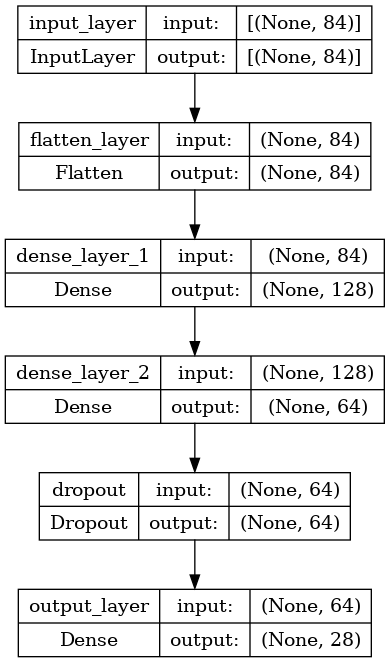

In [17]:
tf.keras.utils.plot_model(stacking_model, show_shapes=True)

In [18]:
stacking_model.fit(ensemble_predictions , y_true, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
30/30 [==============================] - 10s 24ms/step - loss: 0.5986 - accuracy: 0.0867 - auc: 0.5487 - auc_roc: 0.5487 - auc_pr: 0.0862 - precision: 0.0796 - recall: 0.3840 - f1_score: 0.1856 - hamming_loss: 0.2350 - map: 0.2398
Epoch 2/50
30/30 [==============================] - 1s 22ms/step - loss: 0.2985 - accuracy: 0.1017 - auc: 0.5536 - auc_roc: 0.5536 - auc_pr: 0.0690 - precision: 0.1228 - recall: 0.0691 - f1_score: 0.0839 - hamming_loss: 0.0662 - map: 0.2554
Epoch 3/50
30/30 [==============================] - 1s 23ms/step - loss: 0.1902 - accuracy: 0.1831 - auc: 0.6034 - auc_roc: 0.6034 - auc_pr: 0.0928 - precision: 0.4058 - recall: 0.0691 - f1_score: 0.1010 - hamming_loss: 0.0480 - map: 0.3276
Epoch 4/50
30/30 [==============================] - 1s 22ms/step - loss: 0.1606 - accuracy: 0.3587 - auc: 0.7049 - auc_roc: 0.7049 - auc_pr: 0.1647 - precision: 0.7252 - recall: 0.1562 - f1_score: 0.2114 - hamming_loss: 0.0420 - map: 0.4808
Epoch 5/50
30/30 [=================

In [19]:
model1_test_predictions = model1.predict(test_generatorb4)

30/30 [==============================] - 33s 1s/step


In [20]:
model2_test_predictions = model2.predict(test_generatorv2)

30/30 [==============================] - 15s 496ms/step


In [21]:
model3_test_predictions = model3.predict(test_generatorb3)

30/30 [==============================] - 21s 682ms/step


In [22]:
ensemble_test_predictions = np.hstack((model1_test_predictions, model2_test_predictions,model3_test_predictions ))

In [23]:
final_test_predictions = stacking_model.predict(ensemble_test_predictions)

30/30 [==============================] - 1s 3ms/step


In [24]:
labels_test = test_generatorb4.labels
y_true_test = np.array(labels_test)

In [25]:
threshold = 0.5
final_test_predictions_binary = (final_test_predictions > threshold).astype(int)

In [26]:
print(classification_report(y_true_test, final_test_predictions_binary, target_names=labels,digits= 4,zero_division=1))

              precision    recall  f1-score   support

          DR     0.9823    0.9487    0.9652       117
          MH     0.9595    0.7978    0.8712        89
         ODC     0.9778    0.9706    0.9742       136
        TSLN     0.9899    0.9245    0.9561       106
          DN     0.9649    0.9016    0.9322        61
        ARMD     1.0000    0.9344    0.9661        61
         MYA     0.9535    0.9318    0.9425        44
        BRVO     1.0000    0.9592    0.9792        49
         ODP     1.0000    0.9589    0.9790        73
         ODE     1.0000    1.0000    1.0000        48
          LS     0.9688    0.8611    0.9118        36
          RS     1.0000    1.0000    1.0000        22
         CSR     1.0000    0.9643    0.9818        28
         CRS     1.0000    0.9286    0.9630        28
        CRVO     1.0000    1.0000    1.0000        20
        RPEC     1.0000    0.9048    0.9500        21
          MS     1.0000    1.0000    1.0000        20
        AION     1.0000    

In [27]:
evaluation_results = stacking_model.evaluate(ensemble_test_predictions, y_true_test)

30/30 [==============================] - 4s 22ms/step - loss: 0.0163 - accuracy: 0.9003 - auc: 0.9920 - auc_roc: 0.9920 - auc_pr: 0.9795 - precision: 0.9862 - recall: 0.9314 - f1_score: 0.9572 - hamming_loss: 0.0037 - map: 0.9861


### ROC and Precision-Recall Curves

In this code Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves are generated for each class in a classification task.

#### ROC and Precision-Recall Curves

The code snippet calculates and plots ROC and PR curves for each class using the following steps:

- Calculate ROC and PR curves for each class:
  - The code iterates over each class, calculating the False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curves and precision and recall for PR curves.
  - The area under the ROC curve (AUC) is calculated for each class and displayed in the legend.

- Plot ROC Curves:
  - The ROC curves for each class are plotted with distinct colors, and their AUC values are shown in the legend.
  - A diagonal dashed line representing the baseline (random classification) is also plotted.

- Plot Precision-Recall Curves:
  - The PR curves for each class are plotted with distinct colors.

Both ROC and PR curves provide insights into the model's classification performance for multiple classes.


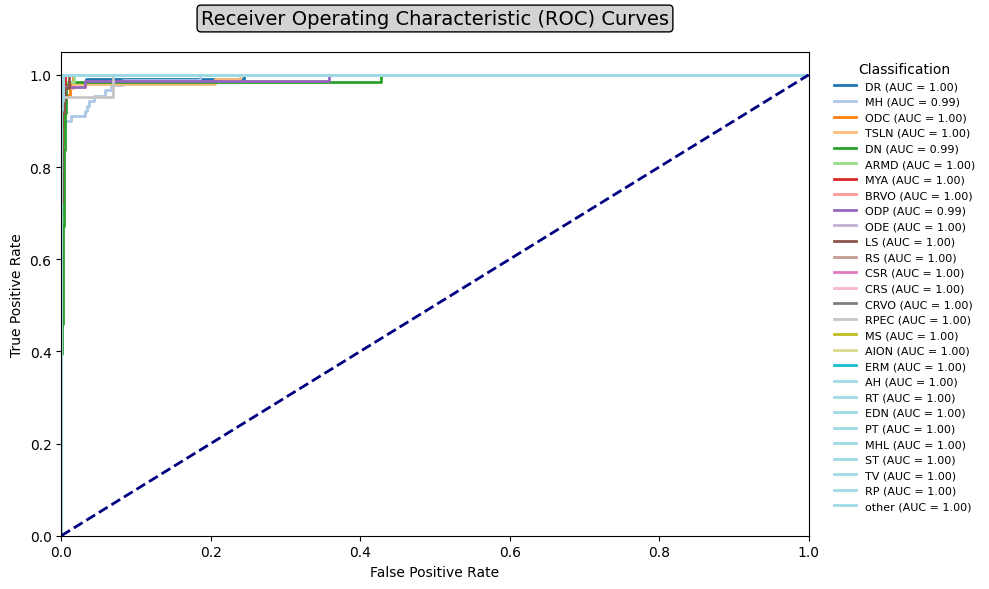

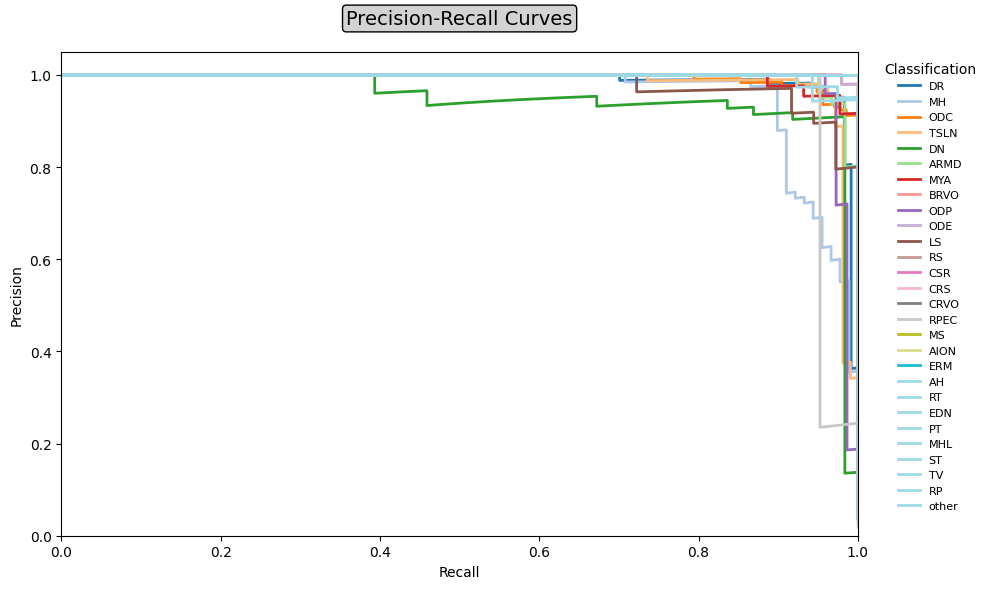

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



n_classes = len(labels)

fig, ax = plt.subplots(figsize=(10, 6))


for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_gen.labels[:, i], preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Precision-recall curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(test_gen.labels[:, i], preds[:, i])
    plt.plot(recall, precision, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  
plt.tight_layout()
plt.show()


In [29]:
model_save_path = 'Stacking_ensemble2.h5'

# Save the model to the specified path
stacking_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to Stacking_ensemble2.h5
